In [15]:
library(ggplot2)
library(gdata)
library(RColorBrewer)
library(NMF)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)
library(ChIPseeker)

Lade nötiges Paket: GenomicFeatures

Lade nötiges Paket: S4Vectors

Lade nötiges Paket: stats4


Attache Paket: ‘S4Vectors’


Das folgende Objekt ist maskiert ‘package:NMF’:

    nrun


Die folgenden Objekte sind maskiert von ‘package:gdata’:

    first, first<-


Die folgenden Objekte sind maskiert von ‘package:data.table’:

    first, second


Die folgenden Objekte sind maskiert von ‘package:base’:

    I, expand.grid, unname


Lade nötiges Paket: IRanges


Attache Paket: ‘IRanges’


Das folgende Objekt ist maskiert ‘package:gdata’:

    trim


Das folgende Objekt ist maskiert ‘package:data.table’:

    shift


Lade nötiges Paket: GenomeInfoDb

Lade nötiges Paket: GenomicRanges

Lade nötiges Paket: AnnotationDbi



Registered S3 method overwritten by 'gplots':
  method         from 
  reorder.factor gdata

ChIPseeker v1.32.1  For help: https://guangchuangyu.github.io/software/ChIPseeker

If you use ChIPseeker in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Qing-Yu He

In [16]:
dmps = read.xls("data/Tables/S1_GR-DMPs.xlsx")
head(dmps)

Warning message:
“'gdata support for Excel files' ist veraltet.
Benutzen Sie stattdessen 'other packages, such as openxlsx, readxl, XLConnect, or xlsx'
Siehe help("Deprecated")”


,CpG,P.value,Chi_sq,FC,Var,FDR,Chr,Pos,Relation_to_Island,UCSC_RefGene_Name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>
1,cg00003858,1.051e-04,15.0422,0.0284,0.0008,0.033524998,chr1,45080600,N_Shelf,RNF220
2,cg00009196,3.093e-06,21.7581,-0.0517,0.0016,0.004841277,chr20,19954588,N_Shore,RIN2
3,cg00023231,9.965e-05,15.1433,-0.0812,0.0032,0.032546969,chr7,156688215,S_Shelf,
4,cg00027232,2.978e-05,17.4315,-0.1217,0.0066,0.016295515,chr2,85547231,OpenSea,TGOLN2
5,cg00027674,6.391e-05,15.9831,-0.0349,0.0009,0.025438826,chr11,87908897,S_Shore,RAB38
6,cg00032703,8.529e-05,15.4372,-0.0864,0.0035,0.029919257,chr11,102329514,OpenSea,


## Panel B - Heatmap

[1] 100 398

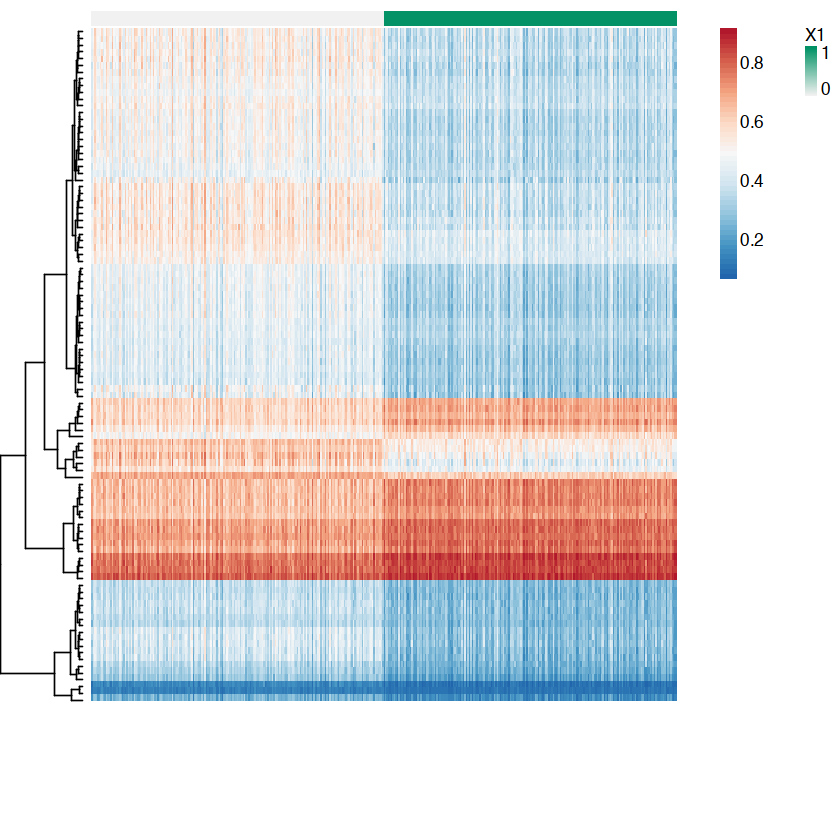

In [14]:
#top100
top.genes.exp = as.data.frame(readRDS("data/Exp_Top100_GR-DMPs.rds"))
#head(top.genes.exp)
heat = t(top.genes.exp[order(top.genes.exp$Dex),-1])
#dim(heat)#100  398
aheatmap(heat,annCol = top.genes.exp[order(top.genes.exp$Dex),]$Dex,
         Rowv=TRUE, Colv = NA,col=rev(brewer.pal(9,"RdBu")))

## Panel C - Barplot (island)

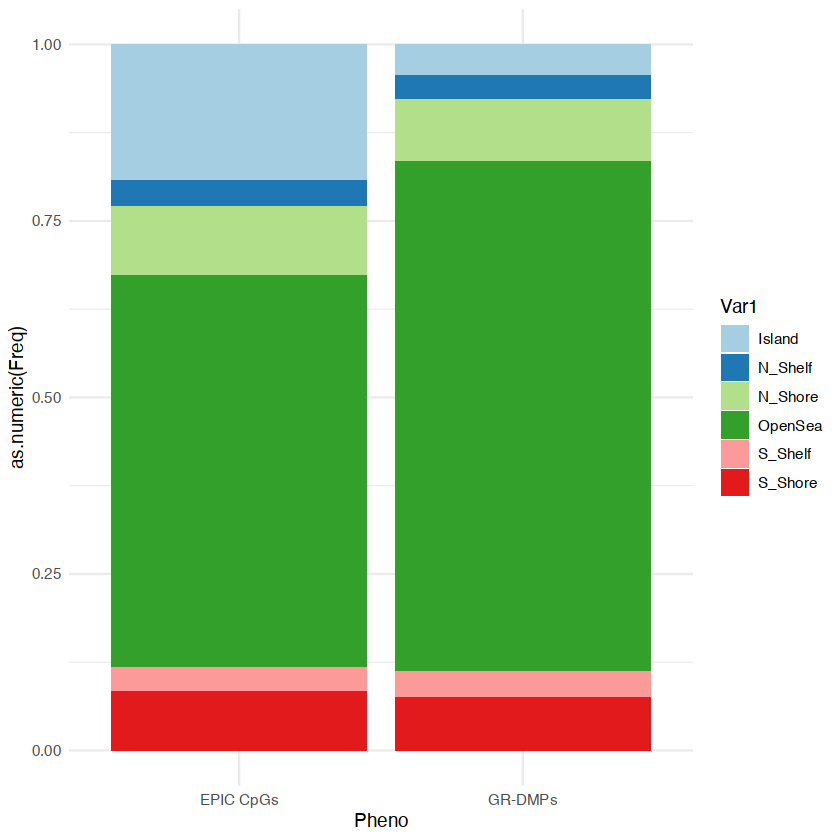

In [17]:
epic.data = readRDS("data/Epic_Annotation.rds")
epic.anno = as.data.frame(table(epic.data$Relation_to_Island))
dmp.anno = as.data.frame(table(dmps$Relation_to_Island))

epic.anno$Freq = (epic.anno$Freq *100)/sum(epic.anno$Freq)
dmp.anno$Freq =  (dmp.anno$Freq *100)/ sum(dmp.anno$Freq)
epic.anno$Pheno="EPIC CpGs"
dmp.anno$Pheno="GR-DMPs"
all = rbind(epic.anno, dmp.anno)

ggplot(data=all , aes(x=Pheno, y=as.numeric(Freq), fill=Var1)) + 
  geom_bar(position = "fill", stat = "identity") + 
  scale_fill_brewer(name='Var1', palette = 'Paired') +
  theme_minimal() 

## Panel D - Bar plot (location)

>> preparing features information...		 2024-01-19 12:05:15 
>> identifying nearest features...		 2024-01-19 12:05:15 
>> calculating distance from peak to TSS...	 2024-01-19 12:05:15 
>> assigning genomic annotation...		 2024-01-19 12:05:15 
>> adding gene annotation...			 2024-01-19 12:05:17 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2024-01-19 12:05:17 
>> done...					 2024-01-19 12:05:17 
>> preparing features information...		 2024-01-19 12:05:17 
>> identifying nearest features...		 2024-01-19 12:05:17 
>> calculating distance from peak to TSS...	 2024-01-19 12:05:27 
>> assigning genomic annotation...		 2024-01-19 12:05:27 
>> adding gene annotation...			 2024-01-19 12:05:38 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2024-01-19 12:05:39 
>> done...					 2024-01-19 12:05:39 


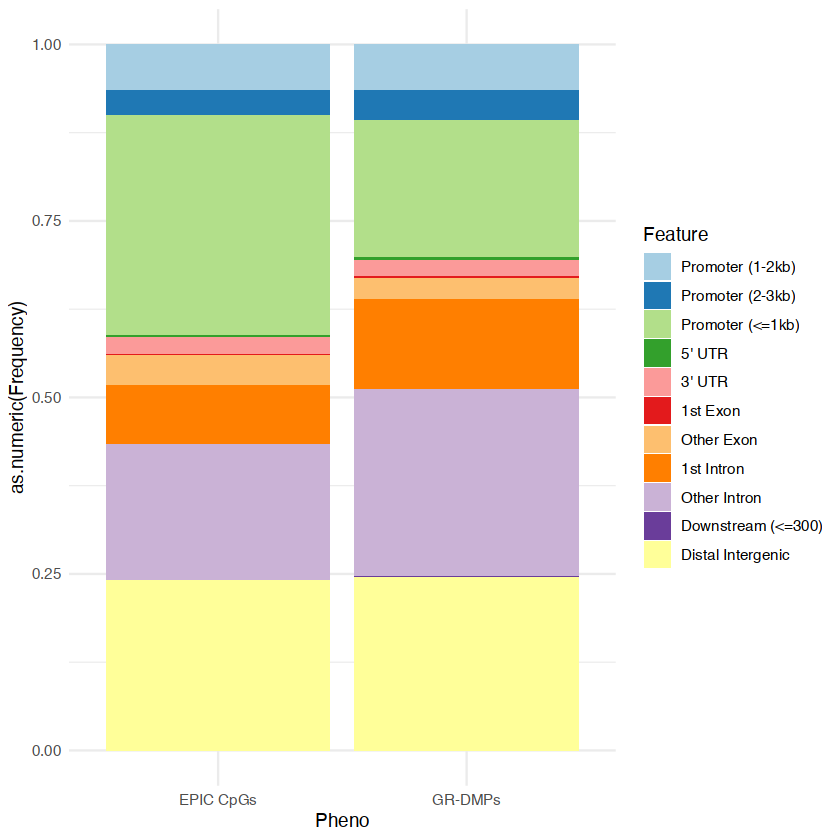

In [23]:
# create GRanges Object
dmp.range = GenomicRanges::GRanges(seqnames = paste0("chr", sapply(dmps$Chr, function(x) unlist(strsplit(x, "chr"))[2])),
                                                 ranges = IRanges::IRanges(start = as.numeric(as.character(dmps$Pos)),
                                                                           end = as.numeric(as.character(dmps$Pos+50))))
names(dmp.range) = dmps$PROBE_ID
                                                      
epic.range = GenomicRanges::GRanges(seqnames = paste0("chr", sapply(epic.data $chr, function(x) unlist(strsplit(x, "chr"))[2])),
                                    ranges = IRanges::IRanges(start = as.numeric(as.character(epic.data$pos)),
                                                              end = as.numeric(as.character(epic.data$pos+50))))
names(epic.range) = epic.data$PROBE_ID

# annotate CpGs
dmp.range.anno = annotatePeak(unique(dmp.range), 
                                TxDb = TxDb.Hsapiens.UCSC.hg19.knownGene, 
                                annoDb = "org.Hs.eg.db")
                                                      
epic.range.anno = annotatePeak(unique(epic.range), 
                               TxDb = TxDb.Hsapiens.UCSC.hg19.knownGene, 
                               annoDb = "org.Hs.eg.db")

# merge and plot
epic.range.anno = epic.range.anno@annoStat
epic.range.anno$Pheno = "EPIC CpGs"
dmp.range.anno = dmp.range.anno@annoStat
dmp.range.anno$Pheno = "GR-DMPs"
plot.data.all = rbind(epic.range.anno, dmp.range.anno)

ggplot(data=plot.data.all , aes(x=Pheno, y=as.numeric(Frequency), fill=Feature)) + 
  geom_bar(position = "fill", stat = "identity") +
  scale_fill_brewer(name='Feature', palette = 'Paired') +
  theme_minimal() 

In [1]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] fansi_1.0.4     crayon_1.5.2    digest_0.6.33   utf8_1.2.3     
 [5] IRdisplay_1.1   repr_1.1.6      lifecycle_1.0.3 jsonlite_1.8.7 
 [9] evaluate_0.21   pillar_1.9.0    rlang_1.1.1     cli_3.6.1      
[13] uuid_1.1-0      vctrs_0.6.3     IRkernel_1.3.2  tools_4.2.1    
[17] glue_1.6.2      fastmap_1.1.1   compiler_4.2.1  base64enc_0.1-3
[21] pbdZMQ_0.3-11   htmltools_0.5.5